# Wildfire Detection System

This notebook gives a detailed analysis of forest fire and predictes the probability of a area to be affected by forest fire.

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load and Download Dataset

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

try:
    df = pd.read_csv(url, header=1)
    print("Dataset loaded successfully")
except:
    np.random.seed(42)
    n_samples = 244

    data = {
        'Temperature': np.random.normal(32, 8, n_samples),
        'RH': np.random.normal(45, 15, n_samples),
        'Ws': np.random.normal(15, 5, n_samples),
        'Rain': np.random.exponential(2, n_samples),
        'FFMC': np.random.normal(85, 10, n_samples),
        'DMC': np.random.normal(25, 15, n_samples),
        'DC': np.random.normal(150, 50, n_samples),
        'ISI': np.random.normal(8, 4, n_samples),
        'BUI': np.random.normal(35, 20, n_samples),
        'FWI': np.random.normal(15, 10, n_samples),
        'Classes': np.random.choice(['fire', 'not fire'], n_samples, p=[0.48, 0.52])
    }
    df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully
Dataset shape: (246, 14)


# Data Preprocessing and Cleaning

Missing values per column:
day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        1
dtype: int64
Final dataset shape: (242, 14)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 3 to 245
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          242 non-null    float64
 1   month        242 non-null    float64
 2   year         242 non-null    float64
 3   Temperature  242 non-null    float64
 4   RH           242 non-null    float64
 5   Ws           242 non-null    float64
 6   Rain         242 non-null    float64
 7   FFMC         242 non-null    float64
 8   DMC          242 non-null    float64
 9   DC           242 non-null    float64
 10  ISI          242 non-null    float64
 11  BUI          242 non-null 

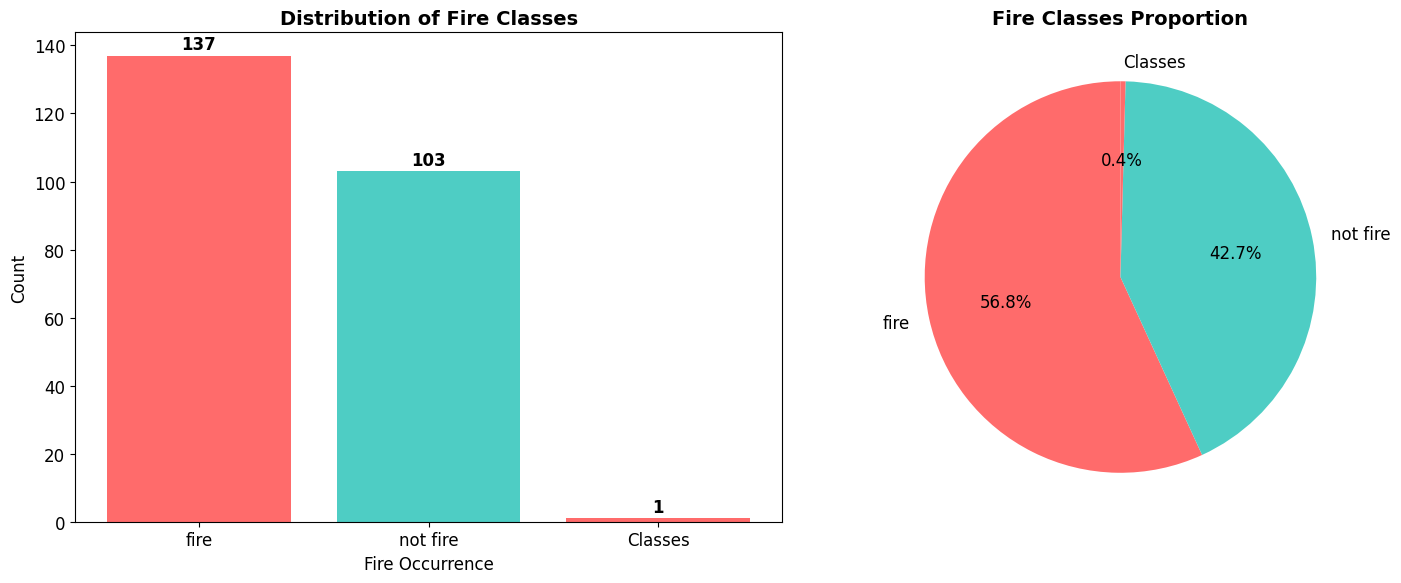

Class distribution:Classes
fire        137
not fire    103
Classes       1
Name: count, dtype: int64
Class balance ratio: 0.01


In [9]:
df = df.iloc[1:]

df.columns = df.columns.str.strip()
if 'Classes' in df.columns:
    df['Classes'] = df['Classes'].str.strip()
elif 'class' in df.columns:
    df['Classes'] = df['class'].str.strip()

print("Missing values per column:")
print(df.isnull().sum())
df = df.dropna(how='all', subset=df.columns[1:])

numerical_cols = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']

for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())


print(f"Final dataset shape: {df.shape}")

print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
class_counts = df['Classes'].value_counts()
ax1.bar(class_counts.index, class_counts.values, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Distribution of Fire Classes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fire Occurrence')
ax1.set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 2, str(v), ha='center', fontweight='bold')

ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
        colors=['#FF6B6B', '#4ECDC4'], startangle=90)
ax2.set_title('Fire Classes Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Class distribution:{class_counts}")
print(f"Class balance ratio: {class_counts.min()/class_counts.max():.2f}")

# Feature Correlation Analysis , Distribution Analysis and Box Plots

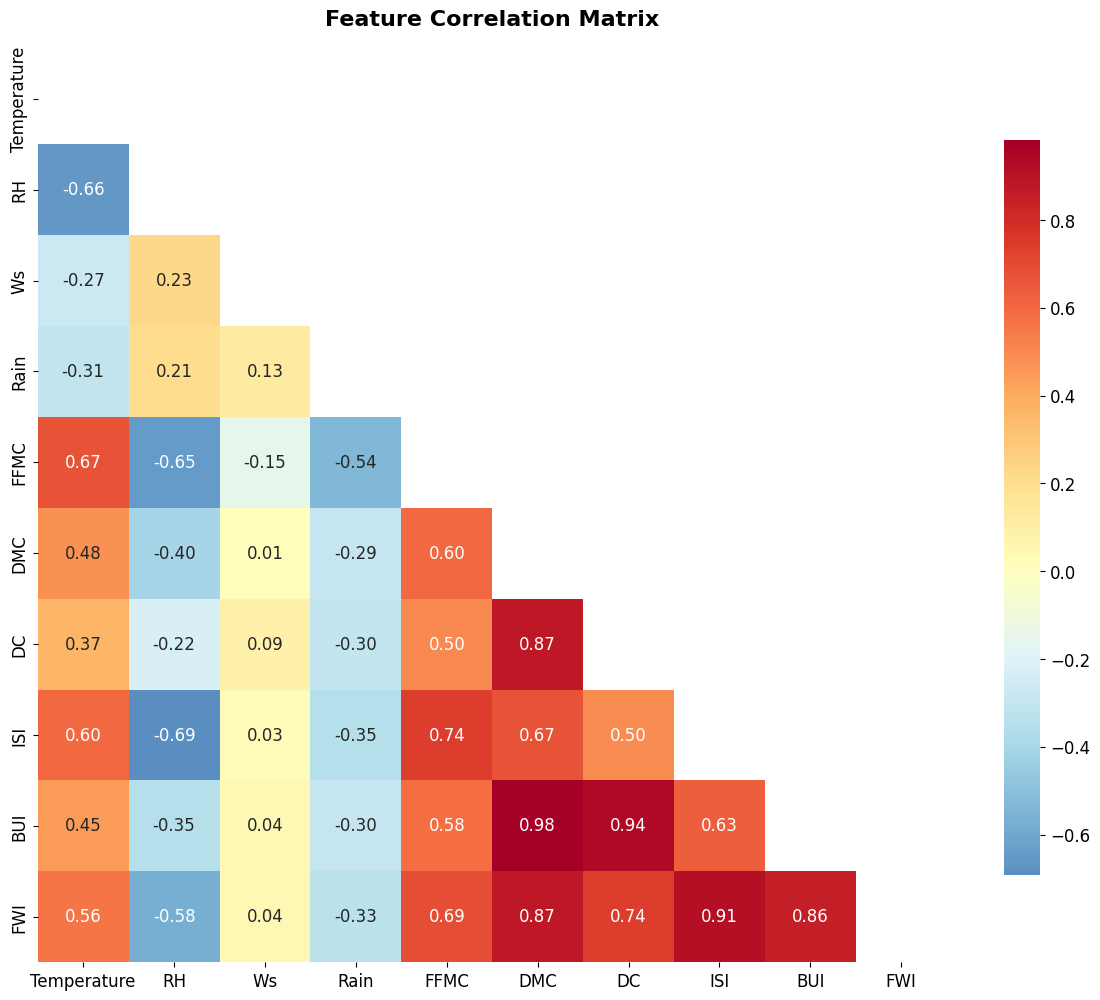

In [10]:
numeric_features = ['Temperature', 'RH', 'Ws', 'Rain']
if 'FFMC' in df.columns:
    numeric_features.extend(['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI'])

correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
            center=0, square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

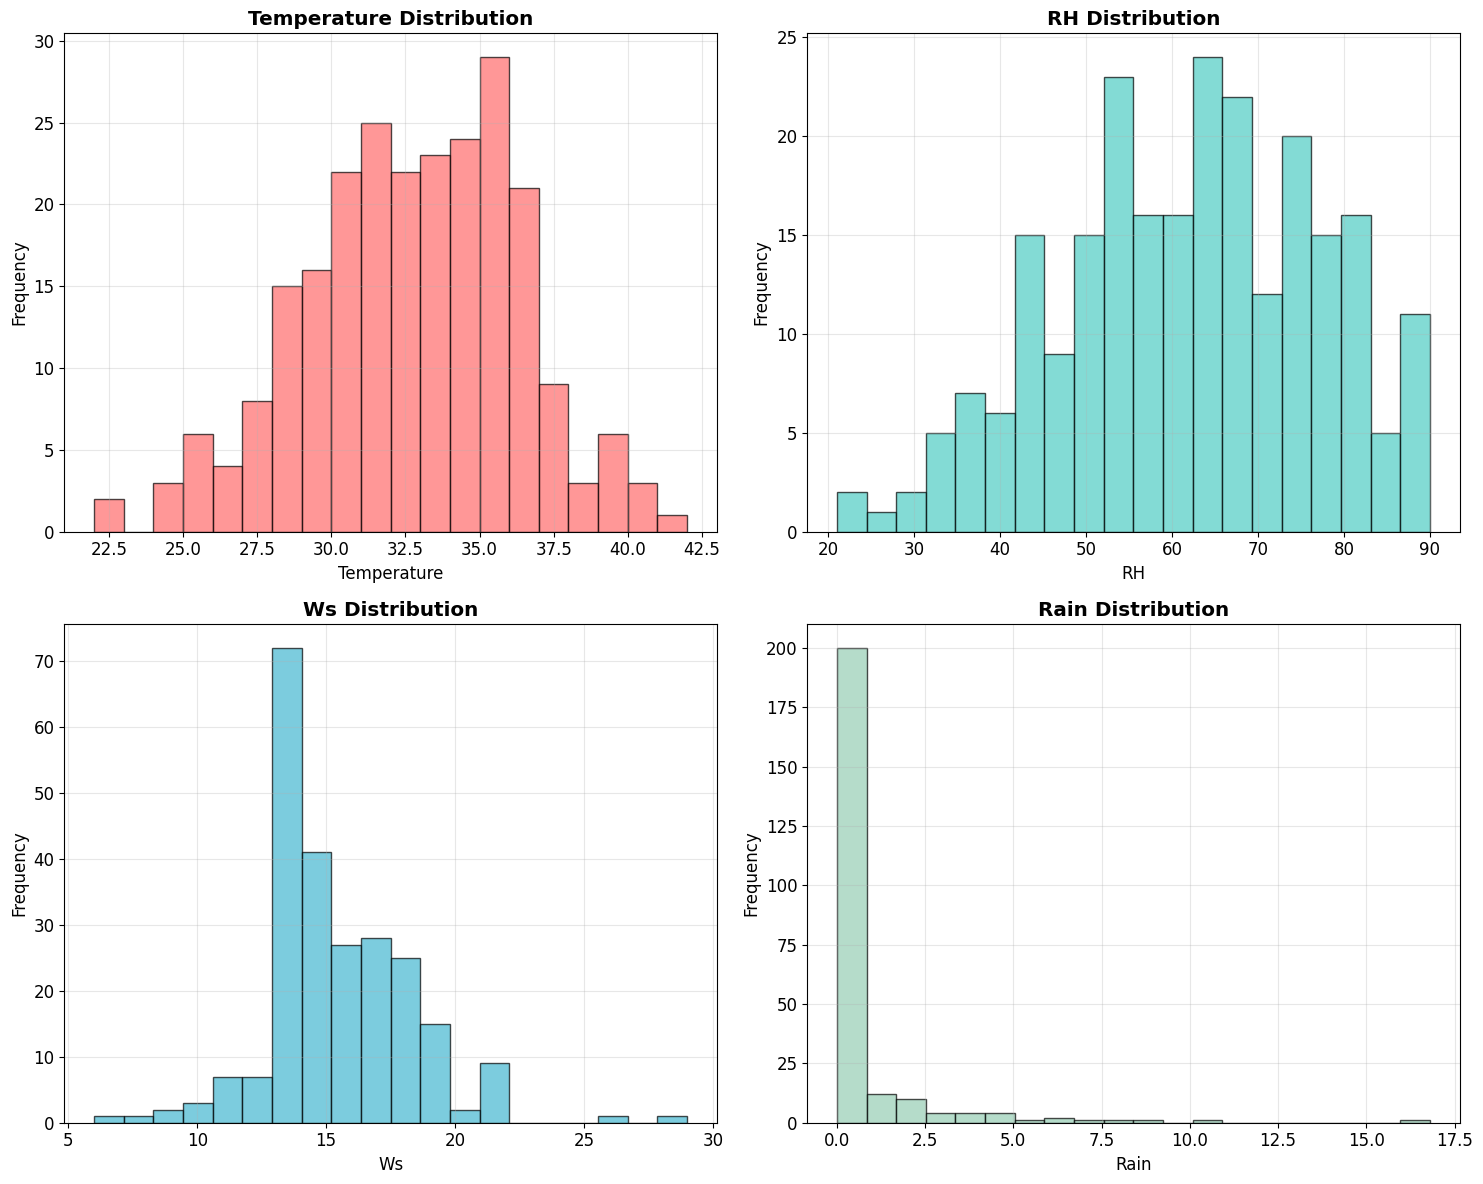

In [11]:
# Distribution Analysis of Weather Features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

weather_features = ['Temperature', 'RH', 'Ws', 'Rain']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        axes[i].hist(df[feature], bins=20, alpha=0.7, color=colors[i], edgecolor='black')
        axes[i].set_title(f'{feature} Distribution', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

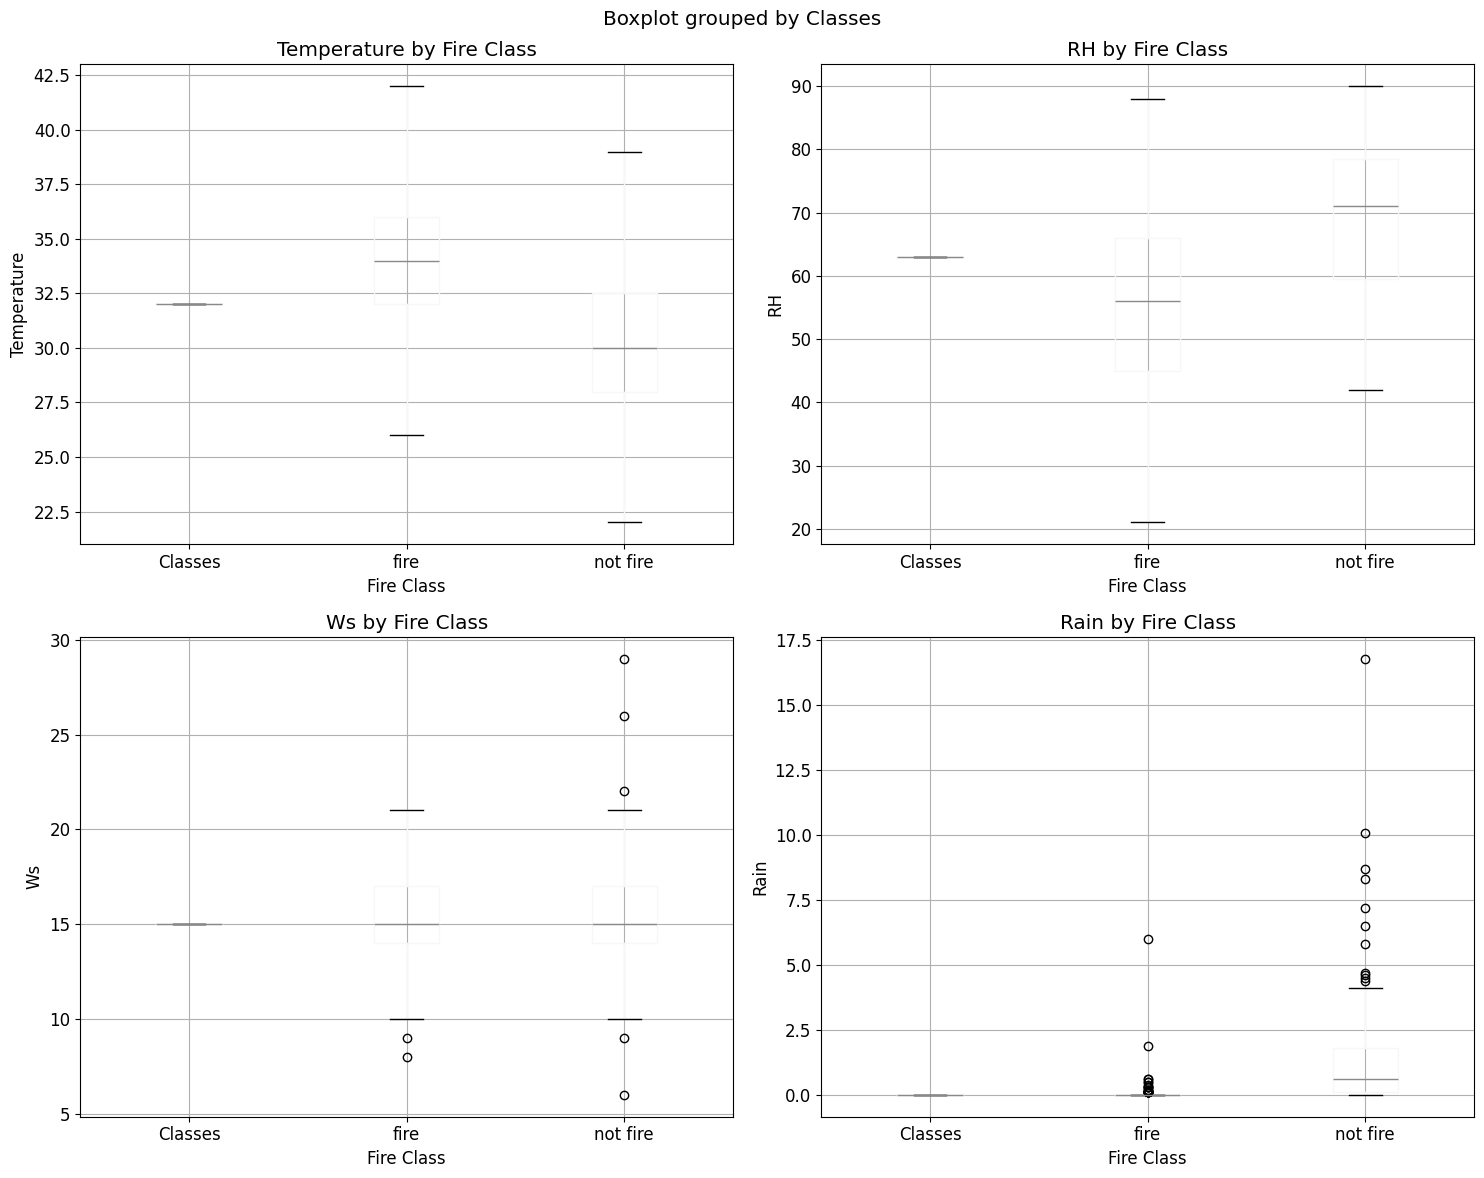

In [12]:
# Box Plots by Fire Class
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        df.boxplot(column=feature, by='Classes', ax=axes[i])
        axes[i].set_title(f'{feature} by Fire Class')
        axes[i].set_xlabel('Fire Class')
        axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# Statistical Analysis and Violin Plots

In [13]:
print("Statistical Analysis by Fire Class:")
print("="*50)

for feature in weather_features:
    if feature in df.columns:
        fire_data = df[df['Classes'] == 'fire'][feature]
        no_fire_data = df[df['Classes'] == 'not fire'][feature]

        t_stat, p_value = stats.ttest_ind(fire_data, no_fire_data)

        print(f"\n{feature}:")
        print(f"Fire days - Mean: {fire_data.mean():.2f}, Std: {fire_data.std():.2f}")
        print(f"No fire days - Mean: {no_fire_data.mean():.2f}, Std: {no_fire_data.std():.2f}")
        print(f"T-test p-value: {p_value:.4f}")
        print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

Statistical Analysis by Fire Class:

Temperature:
Fire days - Mean: 33.80, Std: 2.92
No fire days - Mean: 30.09, Std: 3.37
T-test p-value: 0.0000
Significant difference: Yes

RH:
Fire days - Mean: 56.42, Std: 14.23
No fire days - Mean: 69.39, Std: 12.26
T-test p-value: 0.0000
Significant difference: Yes

Ws:
Fire days - Mean: 15.32, Std: 2.31
No fire days - Mean: 15.66, Std: 3.32
T-test p-value: 0.3522
Significant difference: No

Rain:
Fire days - Mean: 0.10, Std: 0.54
No fire days - Mean: 1.53, Std: 2.54
T-test p-value: 0.0000
Significant difference: Yes


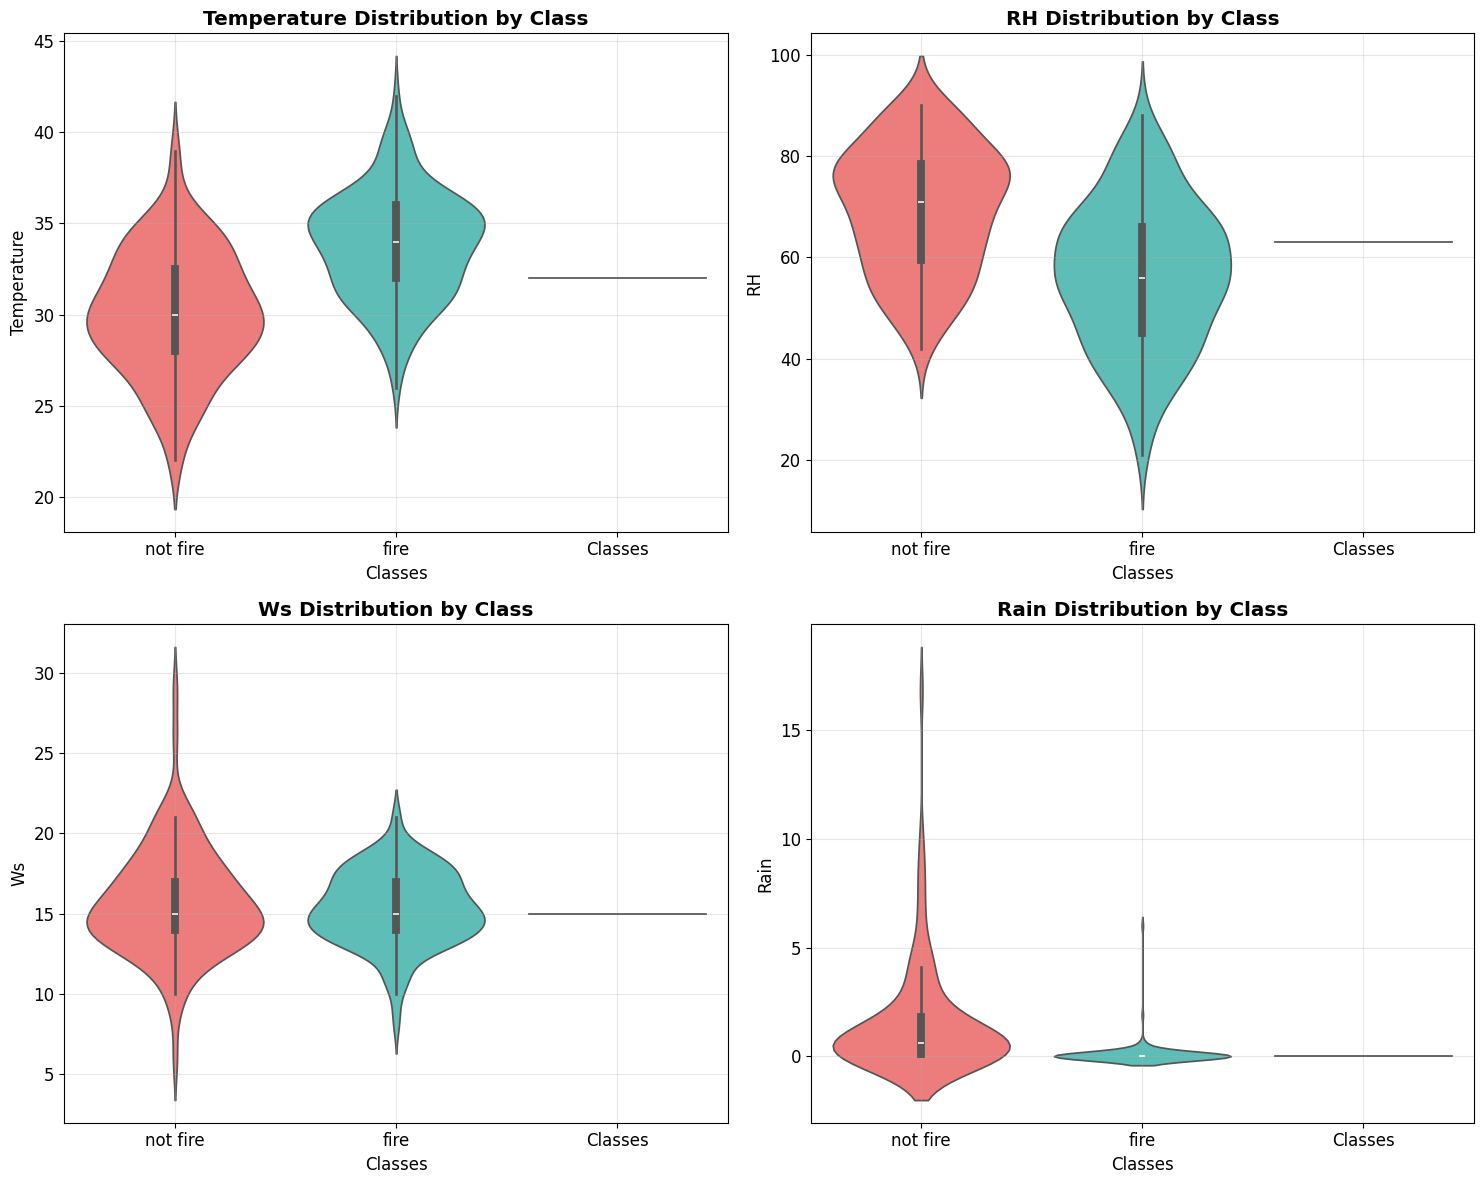

In [14]:
# Violin Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(weather_features):
    if feature in df.columns:
        sns.violinplot(data=df, x='Classes', y=feature, ax=axes[i], palette=['#FF6B6B', '#4ECDC4'])
        axes[i].set_title(f'{feature} Distribution by Class', fontweight='bold')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Engineering

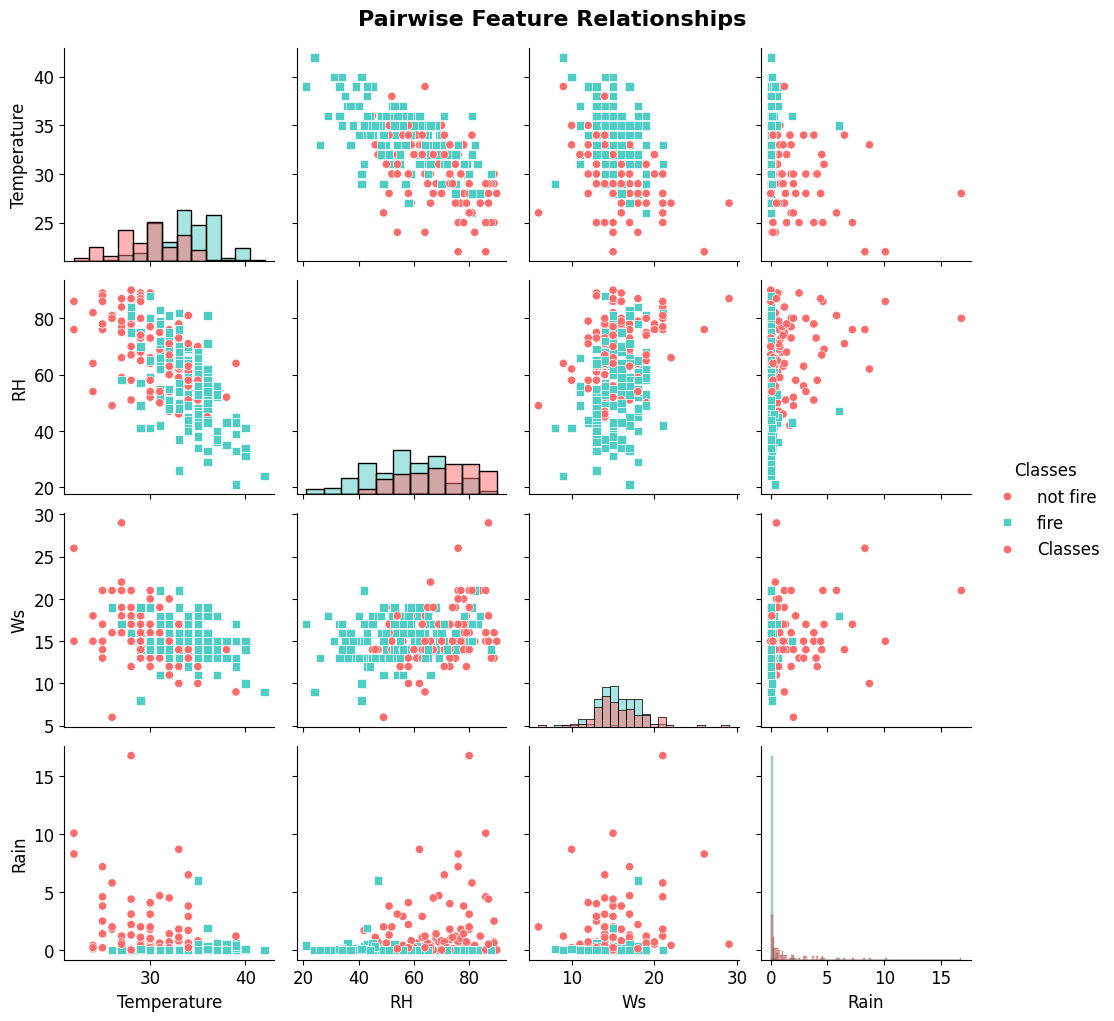

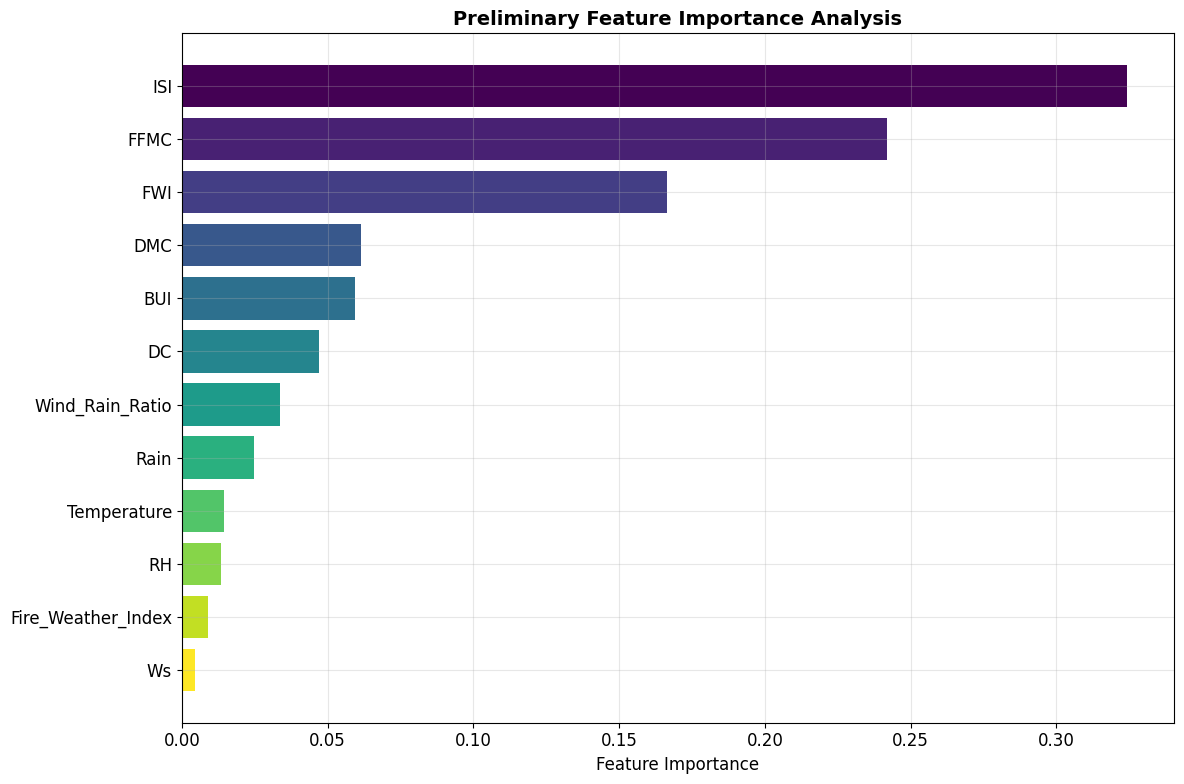

In [15]:
df['Temperature_Risk'] = pd.cut(df['Temperature'], bins=3, labels=['Low', 'Medium', 'High'])
df['RH_Risk'] = pd.cut(df['RH'], bins=3, labels=['Low', 'Medium', 'High'])
df['Wind_Rain_Ratio'] = df['Ws'] / (df['Rain'] + 0.01)  # Avoid division by zero
df['Fire_Weather_Index'] = (df['Temperature'] - df['RH']) * df['Ws'] / (df['Rain'] + 1)
le_temp = LabelEncoder()
le_rh = LabelEncoder()
df['Temperature_Risk_Encoded'] = le_temp.fit_transform(df['Temperature_Risk'])
df['RH_Risk_Encoded'] = le_rh.fit_transform(df['RH_Risk'])

# Pair Plots
key_features = ['Temperature', 'RH', 'Ws', 'Rain', 'Classes']
pair_data = df[key_features].copy()

g = sns.pairplot(pair_data, hue='Classes', palette=['#FF6B6B', '#4ECDC4'],
                 diag_kind='hist', markers=['o', 's'])
g.fig.suptitle('Pairwise Feature Relationships', y=1.02, fontsize=16, fontweight='bold')
plt.show()
X_temp = df[numeric_features + ['Wind_Rain_Ratio', 'Fire_Weather_Index']].fillna(0)
y_temp = df['Classes']

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_temp)

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_encoded)

feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'],
                color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Preliminary Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()